#### Математическое и иммитационное моделирование
Лабораторная работа №3: Вычисление элементарных функций

Чаусов Андрей, M3305

Иванов Данил, M3305

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.interpolate

plt.rcParams['figure.figsize'] = 10, 8

def relative_error(x0, x):
    return np.abs(x0 - x) / np.abs(x0)

epsilon = np.finfo(np.double).eps

### Task 1.

Редукция аргумента

C:\Users\Chausov\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Chausov\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


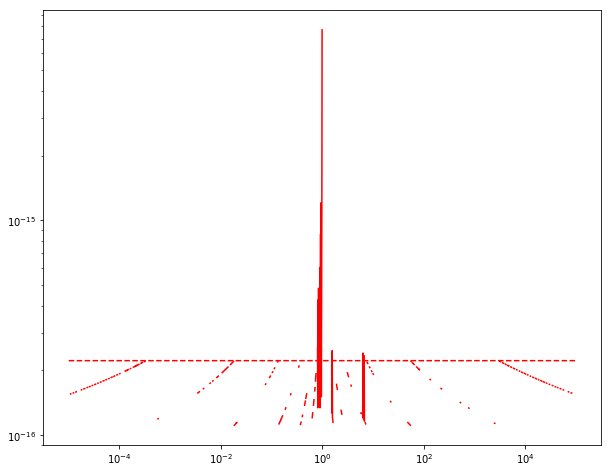

In [6]:
def reduction1(x, eps):
    assert x > 0, 'Invalid argument'
    outer = 1
    
    while not (1 <= x <= 1+eps):
        if x < 1:
            outer = -outer
            x = 1 / x
        else:
            x = np.sqrt(x)
            outer *= 2
            
    return outer, x


def reduction2(x, eps, verbose=True):
    assert x > 0, 'Invalid argument'
    outer = 0
    sgn = 1
    
    x0 = x
    xs = set()
    
    while not (1 <= x <= 1+eps):
        if x < 1:
            x = 1 / x
            sgn = -sgn
        else:
            outer += 1
            x /= 2
        
        if x in xs:
            if verbose:
                print('Division rule reduction cycled')
                return 0, 1, np.exp(1)
            else:
                raise ValueError()
        
        xs |= {x}
        
    return (-1 if x0 < 1 else 1)*outer, sgn, x


def show_task_1(x0, eps=0.1, reduction='both'):
    if reduction in {'type1', 'both'}:
        outer, x = reduction1(x0, eps)
        true_log, our_log = np.log(x0), outer*np.log(x)
        print('Power rule reduction:')
        print('True, Reducted, Rel. error')
        print(true_log, our_log, relative_error(true_log, our_log))
        print()
        
    if reduction in {'type2', 'both'}:
        print('Division rule reduction:')
        outer, sgn, x = reduction2(x0, eps)
        true_log, our_log = np.log(x0), sgn*np.log(x) + outer*np.log(2.)
        print('True, Reducted, Rel. error')
        print(true_log, our_log, relative_error(true_log, our_log))

        
def show_task_1_graph(eps=0.1, reduction='both',
                      st=-5, end=5, num=2001, compare=False):
    
    xs = np.logspace(st, end, num, dtype=np.double)
    y0 = np.log(xs)
    
    epsilon = np.finfo(np.double).eps
    best_precision = (epsilon / 2) * np.abs(1. / np.log(xs))
    
    if reduction in {'type1', 'both'}:
        y1 = []
        for x0 in xs:
            outer, x = reduction1(x0, eps)
            y1.append(outer*np.log(x))
        plt.loglog(xs, relative_error(y0, y1), '-k')
        
    if reduction in {'type2', 'both'}:
        y2 = []
        for x0 in xs:
            try:
                outer, sgn, x = reduction2(x0, eps, verbose=False)
                y2.append(sgn*np.log(x) + outer*np.log(2.))
            except ValueError:
                y2.append(0)

        plt.loglog(xs, relative_error(y0, y2), '-r')
        
#     plt.loglog(xs, best_precision, '--r')
    plt.loglog(xs,[epsilon]*len(xs),"--r")
    plt.show()
    
    if (reduction == 'both' and compare):
        epsilon = np.finfo(np.double).eps
        print(
            sum([1 if x-y>epsilon/2 else 0 
                 for (x, y) 
                 in zip(relative_error(y0, y1), relative_error(y0, y2))]
               )
        )

# show_task_1(0.00001, eps=0.5)
show_task_1_graph(eps=0.5, reduction='type2', compare=True)

### Task 2.

Разложение в степенной ряд

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


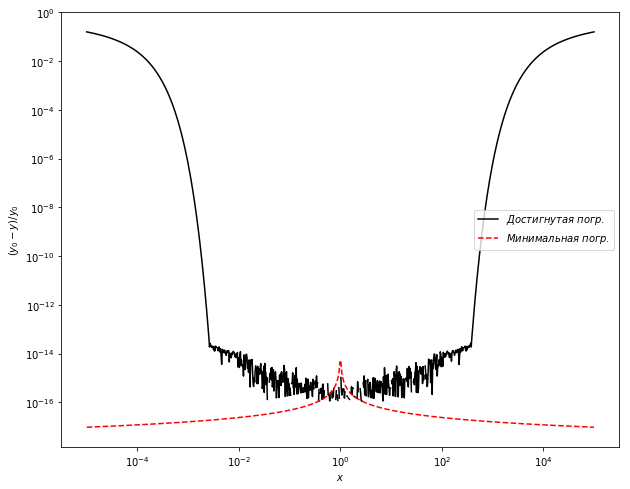

Took 9.646774291992188s


In [3]:
def kahan_sum(x):
    sum_ = 0.0
    error_sum = 0.0
    for elem in x:
        y = elem - error_sum
        t = sum_ + y
        error_sum = (t - sum_) - y
        sum_ = t
    return sum_


def get_derivative(x, n):
    if n == 0:
        return np.log(x)
    else:
        return ((-1) ** (n + 1)) * 1.0 * math.factorial(n - 1) / (x ** n)


def count_r(a, n, thetta=1.0):
    return (a ** (n+1))/math.factorial(n+1) * get_derivative(a*thetta, n+1)


def count_r_new(a, n, thetta=1.0):
    return (-1 if (n+2) & 1 == 1 else 1) / (n+1)
    
    
def poly_sum(x, eps):
    a = x-1
    k = 1
    a_k = a # x в степени k. Сначала k=1
    y = a
    while abs(count_r_new(a, k)) > eps:
        k += 1
        a_k = -a_k * a # последовательно увеличиваем степень и учитываем множитель со знаком
        y += a_k/k
    return y


def foo(x, eps):
    if abs(x) < 1:
        return poly_sum(x, self.eps)
    else:
        return -poly_sum(1/x, self.eps)
    
    
def show_task_2(st=-5, end=5, num=1001, reduction=None, eps=1e-3, r_eps=0.1):
    from time import time
    ts = time()
    
    xs = np.logspace(st, end, num, dtype=np.double)
    
    epsilon = np.finfo(np.double).eps
    best_precision = (epsilon / 2) * np.abs(1. / np.log(xs))

    y0 = np.log(xs)
    y = []
    
    for idx, x in enumerate(xs):
        if reduction is None:
            if abs(x) < 1:
                y.append(poly_sum(x, eps))
            else:
                y.append(-poly_sum(1/x, eps))
                
        elif reduction == 'type1':
            outer, x = reduction1(x, r_eps)
            y.append((-poly_sum(1/x, eps)) * outer)
            
        elif reduction == 'type2':
            try:
                outer, sgn, x = reduction2(x, r_eps, verbose=False)
                y.append(
                    sgn*(-poly_sum(1/x, eps))
                    + outer*np.log(2)
                )
            except ValueError:
                x = xs[idx]
                if abs(x) < 1:
                    y.append(poly_sum(x, eps))
                else:
                    y.append(-poly_sum(1/x, eps))
            
    plt.loglog(xs, relative_error(y0, y),'-k')
    plt.loglog(xs, best_precision, '--r')
    plt.xlabel('$x$')
    plt.ylabel('$(y_0-y)/y_0$')
    plt.legend(["$Достигнутая\;погр.$", "$Минимальная\;погр.$"], loc=5)
    plt.show()
    print('Took {}s'.format(time() - ts))


show_task_2(reduction=None, eps=1e-4)

### Task 3.
Аппроксимация многочленами

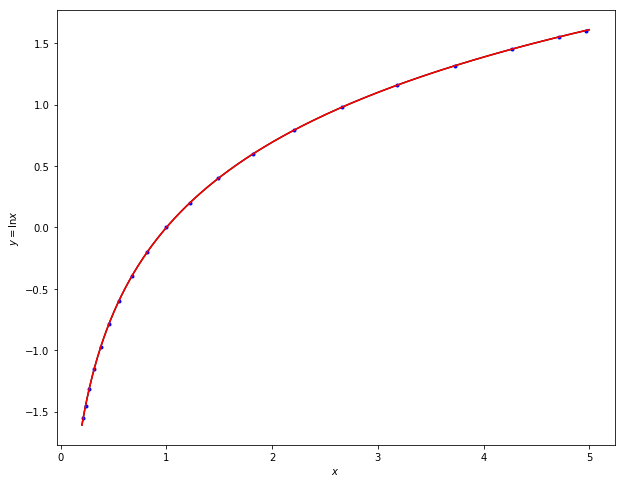

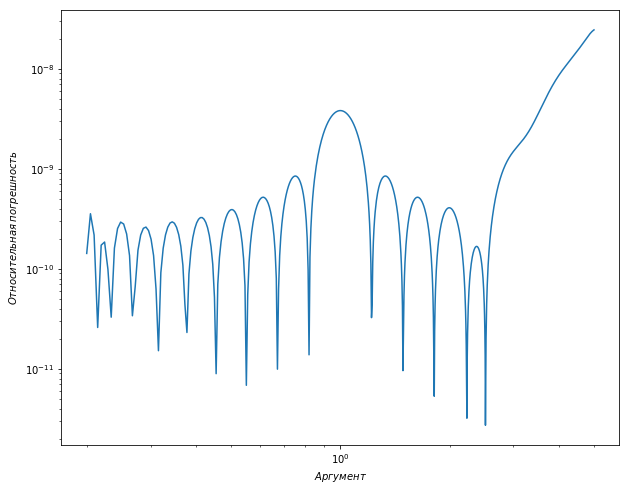

In [24]:
from scipy.interpolate import lagrange, KroghInterpolator


def task_3_lec(*_):
    # Узлы итерполяции
    N=5
    xn=1/5+4.8/(1+np.arange(N))
    yn=np.log(xn)
    # Тестовые точки
    x=np.linspace(1/5, 5, 1000)
    y=np.log(x)
    # Многочлен лагранжа
    L=lagrange(xn,yn)
#     L = KroghInterpolator(xn, yn)
    yl=L(x)
    plt.plot(x,y,'-k')
    plt.plot(xn,yn,'.b')
    plt.plot(x,yl,'-r')
    plt.xlabel("$x$")
    plt.ylabel("$y=\ln x$")
    plt.show()
    plt.semilogy(x,relative_error(y,yl))
    plt.xlabel("$Аргумент$")
    plt.ylabel("$Относительная\;погрешность$")
    plt.show()


def show_task_3(N=5, krogh=False):
    # Interpolation nodes
    un = []
    xn = []
    for n in range(N):
        u = np.cos(np.pi * (n + 0.5) / (N + 1))
        un.append(u)
        xn.append((1 + 2/3*u)/(1 - 2/3*u))
    yn = np.log(xn)
    
    # Test points
    x = np.linspace(1/5, 5, 1000)
    y = np.log(x)
    
    u = (3*x - 3) / (2*(1 + x))
    
    L = lagrange(un, yn)
    if krogh:
        L = KroghInterpolator(un, yn)
    yl = L(u)
    
    plt.plot(x, y, '-k')
    plt.plot(xn, yn, '.b')
    plt.plot(x, yl, '-r')
    plt.xlabel("$x$")
    plt.ylabel("$y=\ln x$")
    plt.show()
    
    plt.loglog(x,relative_error(y,yl))
    plt.xlabel("$Аргумент$")
    plt.ylabel("$Относительная\;погрешность$")
    plt.show()

    
# task_3_lec()
show_task_3(20)

### Task 4.

Итерационный метод

C:\Users\Chausov\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


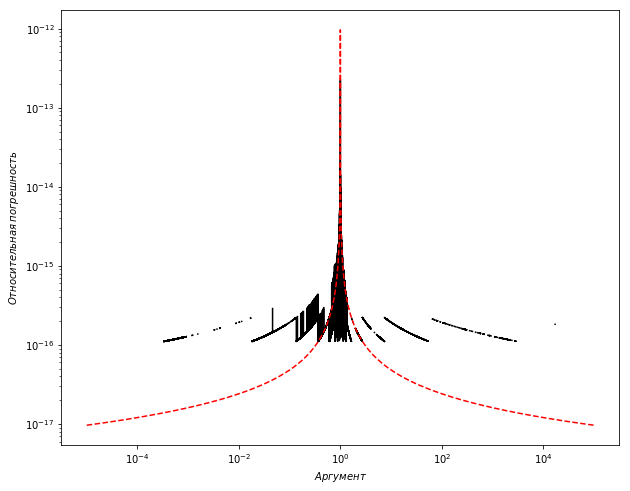

In [7]:
def log_newton(x, N=10):
    y = 1
    for i in range(N):
        y = y - 1 + x/np.exp(y)
    return y

def log_newton_better(x, N=10):
    E = 0
    y_ = x
    sgn = 1
    
    if y_ < 1:
        y_ = 1/y_
        sgn = -1
    
    while y_ > 1:
        y_ /= np.e
        E += 1
        
    y = sgn*E
    for i in range(N):
        y = y - 1 + x/np.exp(y)
    return y

def show_task_4(newton_iter=10):    
    xs = np.logspace(-5, 5, 100000)
    
    epsilon = np.finfo(np.double).eps
    best_precision = (epsilon / 2) * np.abs(1. / np.log(xs))
    
    y0 = np.log(xs)
    y_newton = log_newton(xs, newton_iter)
    ys = []
    
    for x in xs:
        ys.append(log_newton_better(x, newton_iter))

    plt.loglog(xs, relative_error(y0, ys), '-k')
    plt.loglog(xs, best_precision, '--r')
#     plt.loglog(xs, relative_error(y0, y_newton), '-g')
    plt.xlabel("$Аргумент$")
    plt.ylabel("$Относительная\;погрешность$")
    plt.show()


show_task_4(newton_iter=20)

### Task 5.
Вычисление с помощью таблиц

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars


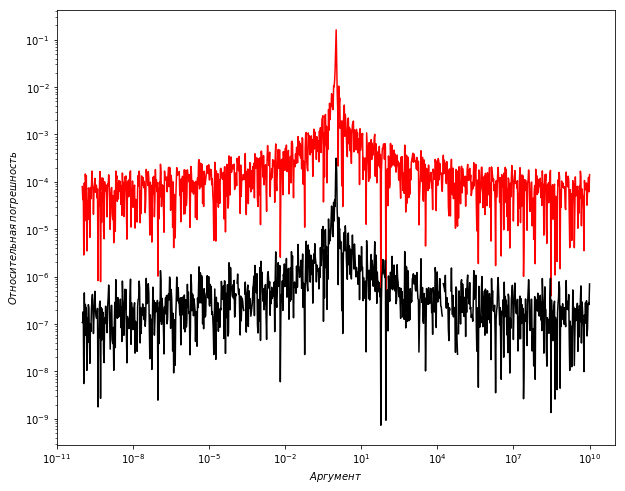

In [22]:
B = 8 # число используемых для составления таблицы бит мантиссы
table_x = (np.arange(0, 2**B, dtype=np.double) + 0.5)/(2**B)
table = np.log(table_x)
log2 = np.log(2)


def log_table(x):
    M, E = np.frexp(x)
    idx = (M * 2**B).astype(np.int)
    return log2*E + table[idx], table_x[idx]*2.**E


def log_table_next(x):
    M, E = np.frexp(x)
    idx = (M * 2**B).astype(np.int) + 1
    
    if idx == len(table):
        E += 1
        idx = 0
        return log2*E + table[idx], table_x[len(table)-1]*2.**(E-1)
        
    return log2*E + table[idx], table_x[idx]*2.**E


def log_table_polinom_one_pow(x):
    y1, x1 = log_table(x)
    y2, x2 = log_table_next(x)
    y_ = y1 + (y2 - y1) * (x - x1) / (x2 - x1)
    return y_


def show_task_5():
    x = np.logspace(-10, 10, 1000)
    y0 = np.log(x)

    y_old = []
    for xi in x:
        y_old.append(log_table(xi)[0])

    y = []
    for xi in x:
        y.append(log_table_polinom_one_pow(xi))

    plt.loglog(x, relative_error(y0, y_old), '-r')
    plt.loglog(x, relative_error(y0, y), '-k')
    plt.xlabel("$Аргумент$")
    plt.ylabel("$Относительная\;погрешность$")
    plt.show()
    
show_task_5()

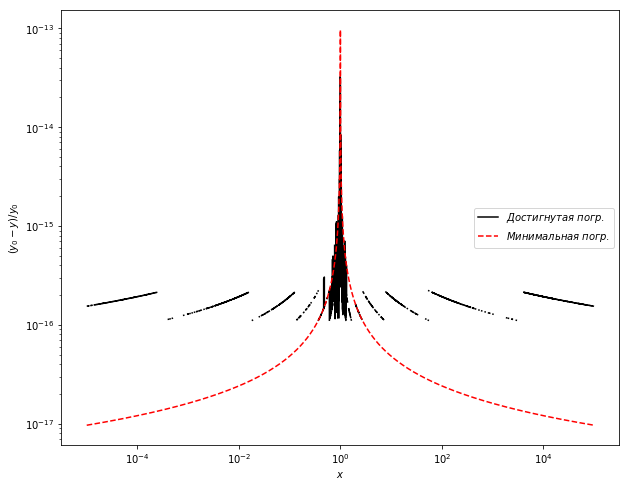

In [25]:
def show_task_6(st=-5, end=5, num=1001, reduction='type1', r_eps=1, newton_iter=20):
    xs = np.logspace(st, end, num, dtype=np.double)
    epsilon = np.finfo(np.double).eps
    best_precision = (epsilon / 2) * np.abs(1. / np.log(xs))

    y0 = np.log(xs)
    y = []
    
    for idx, x in enumerate(xs):                
        if reduction == 'type1':
            outer, x = reduction1(x, r_eps)
            y.append(log_newton_better(x, newton_iter) * outer)
            
        elif reduction == 'type2':
            try:
                outer, sgn, x = reduction2(x, r_eps, verbose=False)
                y.append(
                    sgn*log_newton_better(x, newton_iter)
                    + outer*np.log(2)
                )
            except ValueError:
                x = xs[idx]
                if abs(x) < 1:
                    y.append(-log_newton(1/x))
                else:
                    y.append(log_newton(x))
            
    plt.loglog(xs, relative_error(y0, y),'-k')
    plt.loglog(xs, best_precision, '--r')
    plt.xlabel('$x$')
    plt.ylabel('$(y_0-y)/y_0$')
    plt.legend(["$Достигнутая\;погр.$", "$Минимальная\;погр.$"], loc=5)
    plt.show()

show_task_6(reduction='type2', num=10000)

In [2]:
np.finfo(np.double).eps

2.2204460492503131e-16